## Yelp AZ EDA

**Project:** Yelp AZ Businesses + ACS (Neighborhood Context)  
**Goal:** Understand rating / popularity patterns, business attributes, and neighborhood factors for AZ.

**Setup**
- Import libraries (pandas, numpy, matplotlib, seaborn, json, ast, etc.)
- Set graphic style
- Set file paths

In [66]:
# Cell 1: Setup

import os
import json
import ast

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

# Load library
pd.set_option("display.max_columns", 100)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")
sns.set_theme(style="whitegrid")

# Path Settings
DATA_DIR = "."

BUSINESS_PATH = os.path.join(DATA_DIR, "yelp_academic_dataset_business.json")
REVIEW_PATH   = os.path.join(DATA_DIR, "yelp_academic_dataset_review.json")
ACS_PATH      = os.path.join(DATA_DIR, "acs_phx_2023.csv")

## Phoenix metro 
#PHX_METRO_CITIES = {
#    "Phoenix", "Tempe", "Mesa", "Chandler", "Gilbert",
#    "Scottsdale", "Glendale", "Peoria", "Avondale",
#    "Goodyear", "Surprise"
#}


In [68]:
# Cell 2: Load Yelp business data 

# loding business.json
df_business = pd.read_json(BUSINESS_PATH, lines=True)

print("Raw business shape:", df_business.shape)
df_business.head()


Raw business shape: (150346, 14)


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.43,-119.71,5.00,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.55,-90.34,3.00,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.22,-110.88,3.50,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.96,-75.16,4.00,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.34,-75.47,4.50,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [69]:
# Cell3: Include all AZ merchants as our analysis sample.

df_business_phx = df_business_az.copy()  

# Standardize ZIP codes to 5-character strings
df_business_phx["postal_code"] = (
    df_business_phx["postal_code"]
    .astype(str)
    .str.strip()
    .str.zfill(5)
)

print("Working AZ (Tucson) businesses shape:", df_business_phx.shape)
df_business_phx[[
    "business_id", "name", "city", "state",
    "postal_code", "stars", "review_count", "categories"
]].head()


Working AZ (Tucson) businesses shape: (9912, 15)


,business_id,name,city,state,postal_code,stars,review_count,categories
2,tUFrWirKiKi_TAnsVWINQQ,Target,Tucson,AZ,85711,3.50,22,"Department Stores, Shopping, Fashion, Home & G..."
16,rBmpy_Y1UbBx8ggHlyb7hA,Arizona Truck Outfitters,Tucson,AZ,85705,4.50,10,"Automotive, Auto Parts & Supplies, Auto Custom..."
45,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,Tucson,AZ,85746,3.00,23,"Restaurants, Chinese"
56,txyXRytGjwOXvS8s4sc-WA,Smoothie King,Tucson,AZ,85713,3.00,29,"Vitamins & Supplements, Ice Cream & Frozen Yog..."
67,eYxGFkxo6m3SYGVTh5m2nQ,Big Boyz Toyz Motorcycle Rentals,Tucson,AZ,85712,4.50,8,"Towing, Hotels & Travel, Automotive, Motorcycl..."


In [72]:
# Cell 4: parse attributes and create key features

# 1) Parse attributes into a dictionary
def parse_attributes(x):
    if isinstance(x, dict):
        return x
    if pd.isna(x):
        return {}
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except (ValueError, SyntaxError):
            return {}
    return {}

df_business_phx["attr_dict"] = df_business_phx["attributes"].apply(parse_attributes)

# 2) Price: RestaurantsPriceRange2 (1–4)
df_business_phx["price"] = (
    df_business_phx["attr_dict"]
    .apply(lambda d: d.get("RestaurantsPriceRange2"))
)

df_business_phx["price"] = pd.to_numeric(df_business_phx["price"], errors="coerce")

# 3) log_review_count (exposure)
df_business_phx["log_review_count"] = np.log1p(df_business_phx["review_count"])

# 4) Is it a restaurant? is_restaurant
df_business_phx["is_restaurant"] = (
    df_business_phx["categories"]
    .fillna("")
    .str.contains("Restaurants", case=False)
    .astype(int)
)

# 5) main_category: Retrieve the first tag from the categories array.
def get_main_category(cat_str):
    if pd.isna(cat_str):
        return None
    parts = [c.strip() for c in str(cat_str).split(",") if c.strip()]
    return parts[0] if parts else None

df_business_phx["main_category"] = df_business_phx["categories"].apply(get_main_category)

# Take a look at the current column status
df_business_phx[[
    "business_id", "city", "postal_code",
    "stars", "review_count", "log_review_count",
    "price", "is_restaurant", "main_category"
]].head()


,business_id,city,postal_code,stars,review_count,log_review_count,price,is_restaurant,main_category
2,tUFrWirKiKi_TAnsVWINQQ,Tucson,85711,3.50,22,3.14,2.00,0,Department Stores
16,rBmpy_Y1UbBx8ggHlyb7hA,Tucson,85705,4.50,10,2.40,NaN,0,Automotive
45,wghnIlMb_i5U46HMBGx9ig,Tucson,85746,3.00,23,3.18,2.00,1,Restaurants
56,txyXRytGjwOXvS8s4sc-WA,Tucson,85713,3.00,29,3.40,2.00,0,Vitamins & Supplements
67,eYxGFkxo6m3SYGVTh5m2nQ,Tucson,85712,4.50,8,2.20,NaN,0,Towing


In [74]:
# Cell 5: missingness summary for key columns

cols_check = [
    "stars",
    "review_count",
    "price",
    "categories",
    "attributes",
    "main_category",
]

missing_rate = (
    df_business_phx[cols_check]
    .isna()
    .mean()
    .sort_values(ascending=False)
)

print("Missing rate by column:")
print((missing_rate * 100).round(1).astype(str) + "%")


Missing rate by column:
price            49.5%
attributes       10.0%
categories        0.1%
main_category     0.1%
review_count      0.0%
stars             0.0%
dtype: object


In [76]:
# Cell 6: load ACS ZIP-level data

acs = pd.read_csv(ACS_PATH)

print("ACS Phoenix/AZ ZIP-level shape:", acs.shape)
acs.head()


ACS Phoenix/AZ ZIP-level shape: (47, 4)


,zip,median_income,pct_college,total_pop
0,32246,"78,506.00",39.20,60443
1,85226,"103,740.00",50.00,40974
2,85614,"62,599.00",42.20,24696
3,85619,NaN,50.00,22
4,85623,"68,219.00",40.60,5235


In [82]:
# Cell 7: merge ACS info into business table

#1) Ensure the ZIP file in ACS also has a 5-character string.
acs["zip"] = (
    acs["zip"]
    .astype(str)
    .str.strip()
    .str.zfill(5)
)

# 2) Left join on postal_code ↔ zip
df_business_phx = df_business_phx.merge(
    acs,
    left_on="postal_code",
    right_on="zip",
    how="left"
)

# After merging, a separate ZIP column is no longer required.
df_business_phx = df_business_phx.drop(columns=["zip"])

print("Business + ACS shape:", df_business_phx.shape)
display(
    df_business_phx[[
        "business_id", "city", "postal_code",
        "median_income", "pct_college", "total_pop"
    ]].head()
)

# See how many merchants have successfully matched with ACS
coverage = df_business_phx["median_income"].notna().mean()
print(f"Share of businesses with ACS match: {coverage:.2%}")


Business + ACS shape: (9912, 23)


,business_id,city,postal_code,median_income,pct_college,total_pop
0,tUFrWirKiKi_TAnsVWINQQ,Tucson,85711,"52,358.00",30.50,"41,201.00"
1,rBmpy_Y1UbBx8ggHlyb7hA,Tucson,85705,"36,606.00",20.10,"54,853.00"
2,wghnIlMb_i5U46HMBGx9ig,Tucson,85746,"68,506.00",17.80,"44,030.00"
3,txyXRytGjwOXvS8s4sc-WA,Tucson,85713,"50,264.00",20.60,"45,615.00"
4,eYxGFkxo6m3SYGVTh5m2nQ,Tucson,85712,"48,185.00",37.20,"31,964.00"


Share of businesses with ACS match: 98.66%


In [84]:
# Cell 8: basic descriptive stats for key numeric columns

num_cols = [
    "stars",
    "review_count",
    "log_review_count",
    "price",
    "median_income",
    "pct_college",
    "total_pop",
]

df_business_phx[num_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
stars,"9,912.00",3.59,0.98,1.00,3.00,3.50,4.50,5.00
review_count,"9,912.00",41.63,86.34,5.00,8.00,15.00,36.00,"2,126.00"
log_review_count,"9,912.00",3.02,1.05,1.79,2.20,2.77,3.61,7.66
price,"5,001.00",1.72,0.66,1.00,1.00,2.00,2.00,4.00
median_income,"9,779.00","62,856.77","22,846.46","36,606.00","47,093.00","52,672.00","76,915.00","121,647.00"
pct_college,"9,833.00",37.28,14.61,0.00,29.70,37.20,46.00,72.20
total_pop,"9,862.00","36,720.33","13,557.74",0.00,"30,198.00","34,608.00","49,609.00","60,443.00"


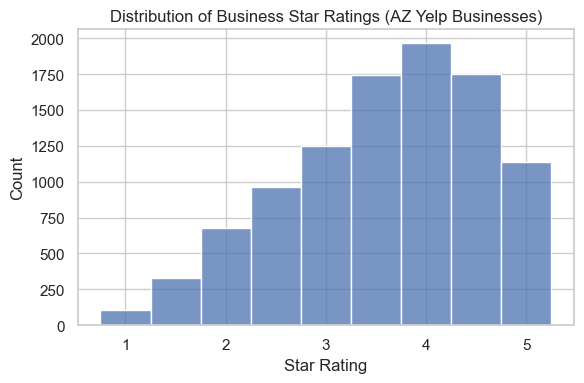

In [27]:
# Cell 9: distribution of business star ratings (AZ / Tucson)

plt.figure(figsize=(6, 4))
sns.histplot(
    df_business_phx["stars"],
    bins=np.arange(0.75, 5.26, 0.5),  # 1.0,1.5,...,5.0
    kde=False
)
plt.title("Distribution of Business Star Ratings (AZ Yelp Businesses)")
plt.xlabel("Star Rating")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


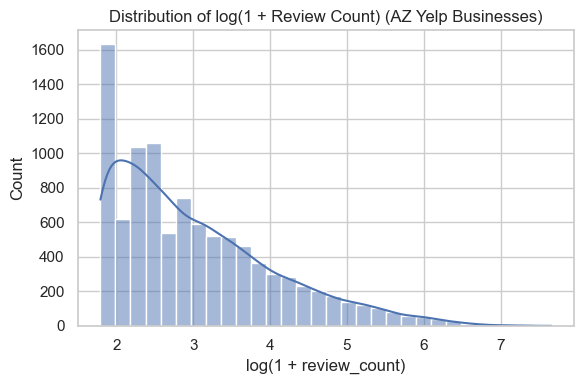

In [29]:
# Cell 10: distribution of log(review_count + 1)

plt.figure(figsize=(6, 4))
sns.histplot(
    df_business_phx["log_review_count"],
    bins=30,
    kde=True
)
plt.title("Distribution of log(1 + Review Count) (AZ Yelp Businesses)")
plt.xlabel("log(1 + review_count)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


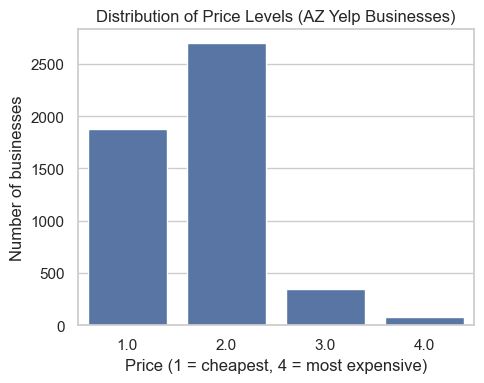

In [31]:
# Cell 11: distribution of price levels

plt.figure(figsize=(5, 4))
sns.countplot(
    data=df_business_phx,
    x="price",
    order=sorted(df_business_phx["price"].dropna().unique())
)
plt.title("Distribution of Price Levels (AZ Yelp Businesses)")
plt.xlabel("Price (1 = cheapest, 4 = most expensive)")
plt.ylabel("Number of businesses")
plt.tight_layout()
plt.show()


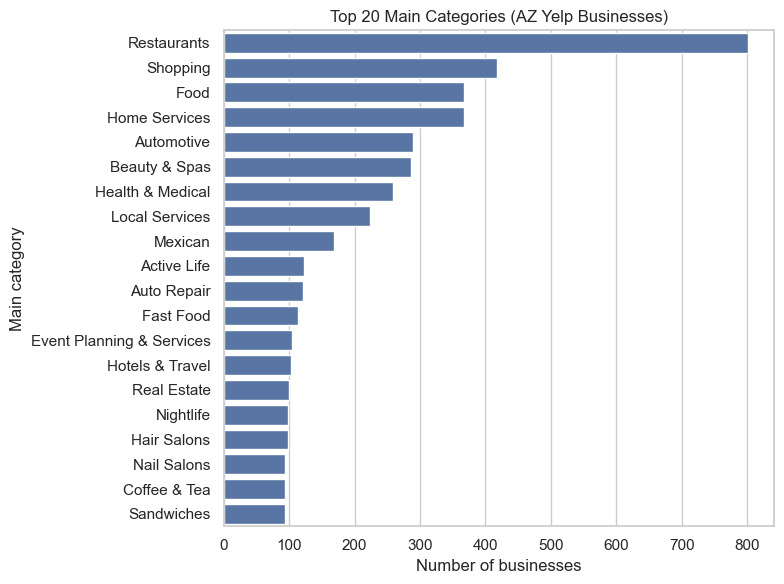

In [33]:
# Cell 12: top main categories

top_main_cat = (
    df_business_phx["main_category"]
    .value_counts()
    .head(20)
)

plt.figure(figsize=(8, 6))
sns.barplot(
    x=top_main_cat.values,
    y=top_main_cat.index
)
plt.title("Top 20 Main Categories (AZ Yelp Businesses)")
plt.xlabel("Number of businesses")
plt.ylabel("Main category")
plt.tight_layout()
plt.show()

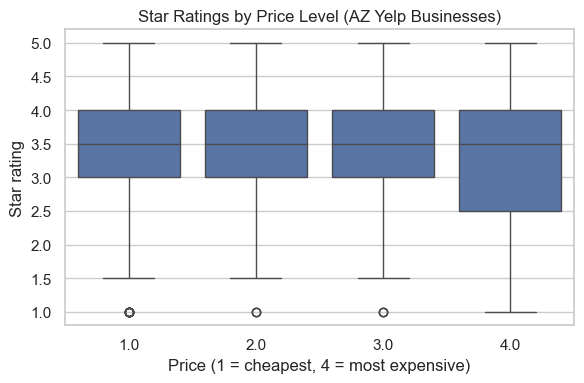

In [35]:
# Cell 13: star rating by price level

plt.figure(figsize=(6, 4))
sns.boxplot(
    data=df_business_phx,
    x="price",
    y="stars"
)
plt.title("Star Ratings by Price Level (AZ Yelp Businesses)")
plt.xlabel("Price (1 = cheapest, 4 = most expensive)")
plt.ylabel("Star rating")
plt.tight_layout()
plt.show()


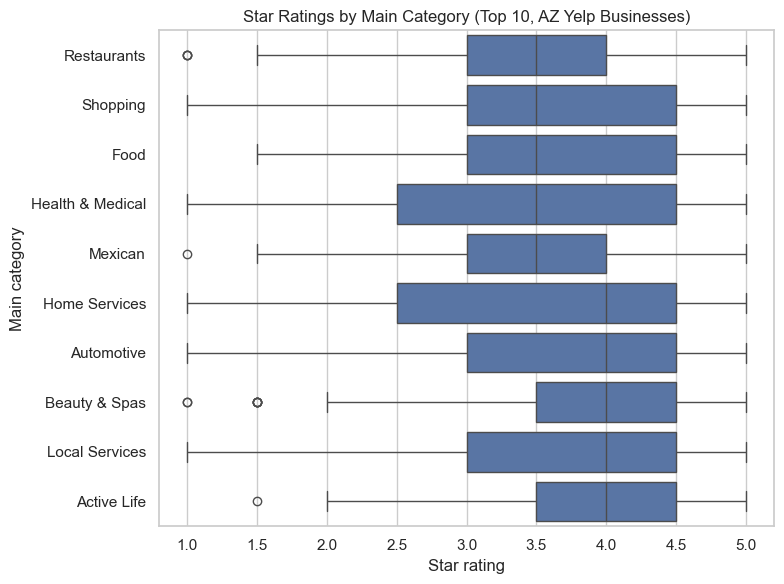

In [37]:
# Cell 14: star ratings by main category (top 10 categories)

top10_cats = (
    df_business_phx["main_category"]
    .value_counts()
    .head(10)
    .index
)

plt.figure(figsize=(8, 6))
sns.boxplot(
    data=df_business_phx[df_business_phx["main_category"].isin(top10_cats)],
    y="main_category",
    x="stars",
    order=sorted(top10_cats, key=lambda c: df_business_phx[df_business_phx["main_category"] == c]["stars"].median())
)
plt.title("Star Ratings by Main Category (Top 10, AZ Yelp Businesses)")
plt.xlabel("Star rating")
plt.ylabel("Main category")
plt.tight_layout()
plt.show()


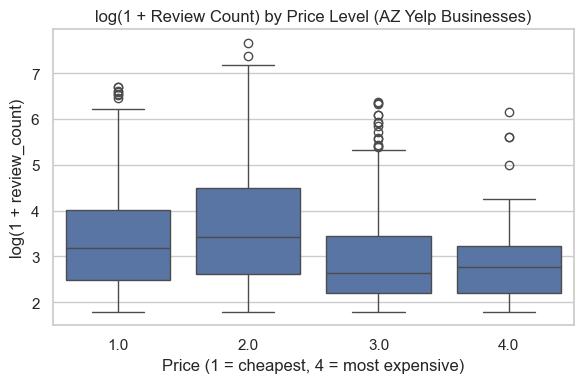

In [39]:
# Cell 15: log(1 + review_count) by price level

plt.figure(figsize=(6, 4))
sns.boxplot(
    data=df_business_phx,
    x="price",
    y="log_review_count"
)
plt.title("log(1 + Review Count) by Price Level (AZ Yelp Businesses)")
plt.xlabel("Price (1 = cheapest, 4 = most expensive)")
plt.ylabel("log(1 + review_count)")
plt.tight_layout()
plt.show()


In [41]:
# Cell 16: create income quartiles based on median_income

# Keep only rows with non-missing income for the bins
income_nonmissing = df_business_phx["median_income"].dropna()

# Define quartile labels
income_labels = [
    "Q1 (lowest income)",
    "Q2",
    "Q3",
    "Q4 (highest income)"
]

# Use qcut to assign quartiles
df_business_phx["income_quartile"] = pd.qcut(
    df_business_phx["median_income"],
    q=4,
    labels=income_labels
)

df_business_phx[["median_income", "income_quartile"]].head()


,median_income,income_quartile
0,"52,358.00",Q2
1,"36,606.00",Q1 (lowest income)
2,"68,506.00",Q3
3,"50,264.00",Q2
4,"48,185.00",Q2


In [43]:
# Cell 17: stars and log_review_count by income quartile

# Drop rows without income_quartile
df_income = df_business_phx.dropna(subset=["income_quartile"]).copy()

# Group means
group_means = (
    df_income
    .groupby("income_quartile")[["stars", "log_review_count"]]
    .mean()
    .reindex([
        "Q1 (lowest income)",
        "Q2",
        "Q3",
        "Q4 (highest income)"
    ])
)

group_means


C:\Users\53412\AppData\Local\Temp\ipykernel_135324\2800925097.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("income_quartile")[["stars", "log_review_count"]]


,stars,log_review_count
income_quartile,,
Q1 (lowest income),3.64,3.09
Q2,3.59,3.04
Q3,3.48,2.97
Q4 (highest income),3.66,3.00


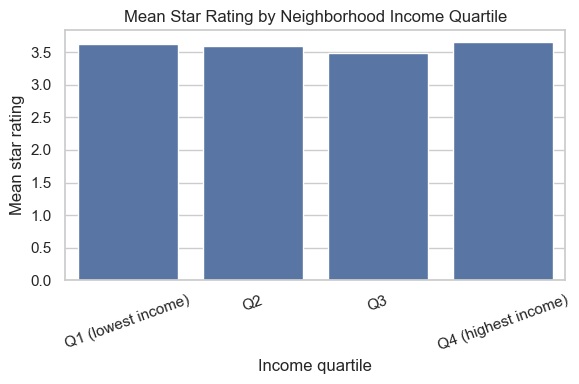

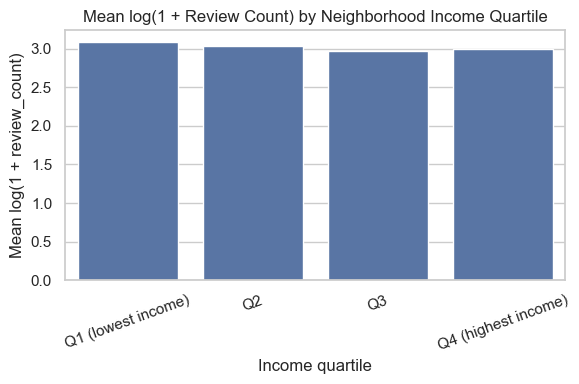

In [45]:
# Cell 18: plot mean stars by income quartile

plt.figure(figsize=(6, 4))
sns.barplot(
    x=group_means.index,
    y=group_means["stars"].values
)
plt.title("Mean Star Rating by Neighborhood Income Quartile")
plt.xlabel("Income quartile")
plt.ylabel("Mean star rating")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# Cell 19: plot mean log_review_count by income quartile

plt.figure(figsize=(6, 4))
sns.barplot(
    x=group_means.index,
    y=group_means["log_review_count"].values
)
plt.title("Mean log(1 + Review Count) by Neighborhood Income Quartile")
plt.xlabel("Income quartile")
plt.ylabel("Mean log(1 + review_count)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


In [47]:
# Cell 20: correlation matrix for key numeric variables

corr_cols = [
    "stars",
    "log_review_count",
    "price",
    "median_income",
    "pct_college",
    "total_pop",
]

corr_matrix = df_business_phx[corr_cols].corr()

corr_matrix


,stars,log_review_count,price,median_income,pct_college,total_pop
stars,1.00,0.01,0.07,0.01,0.10,-0.05
log_review_count,0.01,1.00,-0.00,-0.02,0.08,-0.02
price,0.07,-0.00,1.00,0.11,0.16,-0.08
median_income,0.01,-0.02,0.11,1.00,0.59,-0.56
pct_college,0.10,0.08,0.16,0.59,1.00,-0.50
total_pop,-0.05,-0.02,-0.08,-0.56,-0.50,1.00


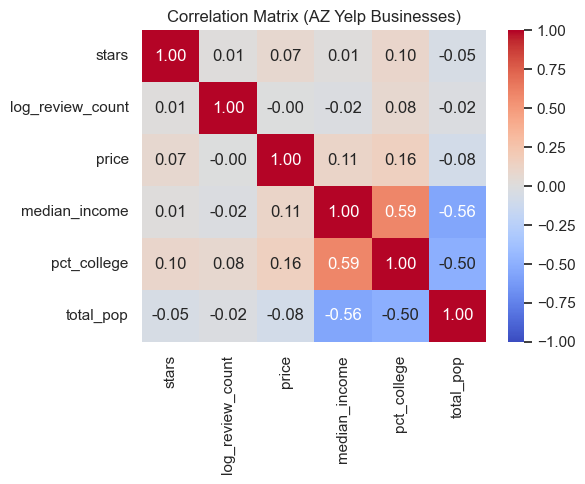

In [49]:
# Cell 21: heatmap of correlations

plt.figure(figsize=(6, 5))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1
)
plt.title("Correlation Matrix (AZ Yelp Businesses)")
plt.tight_layout()
plt.show()


In [51]:
# Cell 22: import statsmodels for simple exploratory models

import statsmodels.api as sm
import statsmodels.formula.api as smf


In [52]:
# Cell 23: OLS model – star rating as outcome
# Predictors: price, log_review_count, median_income, pct_college

model_data = df_business_phx[[
    "stars",
    "price",
    "log_review_count",
    "median_income",
    "pct_college"
]].dropna()

ols_model = smf.ols(
    formula="stars ~ price + log_review_count + median_income + pct_college",
    data=model_data
).fit()

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  stars   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     63.61
Date:                Sun, 09 Nov 2025   Prob (F-statistic):           1.62e-52
Time:                        22:32:31   Log-Likelihood:                -6143.8
No. Observations:                4954   AIC:                         1.230e+04
Df Residuals:                    4949   BIC:                         1.233e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            3.0786      0.057  

In [55]:
# Cell 24: logistic regression – high rating vs others (optional)

logit_data = model_data.copy()
logit_data["high_rating"] = (logit_data["stars"] >= 4.0).astype(int)

logit_model = smf.logit(
    formula="high_rating ~ price + log_review_count + median_income + pct_college",
    data=logit_data
).fit()

print(logit_model.summary())


Optimization terminated successfully.
         Current function value: 0.667850
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:            high_rating   No. Observations:                 4954
Model:                          Logit   Df Residuals:                     4949
Method:                           MLE   Df Model:                            4
Date:                Sun, 09 Nov 2025   Pseudo R-squ.:                 0.02802
Time:                        22:32:31   Log-Likelihood:                -3308.5
converged:                       True   LL-Null:                       -3403.9
Covariance Type:            nonrobust   LLR p-value:                 3.597e-40
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -1.0190      0.142     -7.191      0.000      -1.297      -0.741
price      

### Exploratory regression results (interpretation)

We fit two simple models using Arizona Yelp businesses:

1. **OLS: star rating as a continuous outcome**

- `price` has a small positive coefficient (~0.08): more expensive businesses tend to have slightly higher ratings, holding other variables constant.
- `log_review_count` is also positive (~0.06): businesses with more reviews tend to have marginally higher ratings.
- `median_income` has a very small **negative** coefficient: businesses in higher-income ZIP codes have slightly lower ratings on average, although the effect size per dollar is tiny.
- `pct_college` is positive: neighborhoods with a higher share of college-educated residents are associated with higher ratings.
- The **R² is low (~0.05)**, meaning these variables explain only a small share of the variation in ratings.

2. **Logit: high rating (stars ≥ 4) vs. others**

- Signs of the coefficients are similar:
  - `price` and `log_review_count` increase the odds of being highly rated.
  - `median_income` decreases the odds.
  - `pct_college` increases the odds.
- Pseudo R² is small (~0.03), again indicating limited explanatory power.

Overall, these models suggest that **business-level factors (price, popularity) and neighborhood education levels** are modestly associated with ratings, while neighborhood income shows a small negative association. However, the models have low explanatory power and are used only for **exploratory purposes**, not causal inference.

## 4. Discussion and implications of the EDA

**Key takeaways from the Arizona Yelp businesses + ACS EDA**

- Business ratings in Arizona are tightly concentrated between 3 and 5 stars, with very few extremely low-rated businesses.
- Review counts are highly skewed: most businesses receive only a small number of reviews, while a small subset has very large exposure; using `log(1 + review_count)` is necessary to stabilize this distribution.
- The local business mix is dominated by service sectors such as Restaurants, Shopping, Food, Home Services, Automotive, and Beauty & Spas.
- Price levels are mostly in the lower tiers (1–2), and higher price levels show only modestly higher average ratings and exposure.
- Across major categories, median ratings are relatively similar, but some service categories (e.g., Beauty & Spas, Health & Medical) show slightly higher typical ratings than others.
- Neighborhood-level ACS measures are well matched to businesses: most Arizona businesses can be linked to a ZIP code with income, education, and population information.
- Quartile splits of neighborhood median income show only small differences in both ratings and exposure, but areas with higher education shares (`pct_college`) tend to have slightly higher ratings.
- Simple exploratory regression models indicate that price, log review count, and neighborhood education are positively associated with higher ratings, while neighborhood income shows a small negative association; however, the models have low explanatory power and should not be interpreted causally.
- Overall, the EDA highlights a heavy-tailed “attention economy” for Yelp businesses, a fairly stable rating distribution, and only modest associations between neighborhood SES and business outcomes.


### Summary of the Arizona Yelp ecosystem

Our exploratory analysis of Arizona Yelp businesses shows a platform where most businesses are rated between 3 and 5 stars, with relatively few extreme outliers. At the same time, review counts are very unevenly distributed: a small fraction of businesses attract a large share of total reviews, while many others remain relatively invisible. The local business landscape is dominated by service-oriented categories such as restaurants, shopping, personal care, and home services, and most businesses operate at lower price points.

Neighborhood context from ACS data provides additional structure but does not fully explain rating or exposure differences. After linking businesses to ZIP-level median income, education, and population, we find only modest variation in ratings across income quartiles, and similar levels of exposure measured by `log(1 + review_count)`. Education levels show a somewhat stronger positive association with ratings than income does, suggesting that the composition of local consumers may matter more than income alone.

Simple linear and logistic regression models, used purely for exploratory purposes, reinforce this picture. Higher price levels, greater review volume, and higher neighborhood education are associated with slightly higher ratings and a greater probability of being highly rated, while median income has a small negative coefficient. However, the models explain only a small share of the variation in ratings, indicating that unobserved factors such as business quality, management, competition, and unmeasured neighborhood characteristics likely play a large role.

From a modeling perspective, these findings suggest that future work should: (i) account for the heavy-tailed nature of review counts (e.g., using log transforms or robust measures), (ii) treat neighborhood variables as contextual rather than dominant predictors, and (iii) consider richer business-level features (e.g., detailed amenities or review text features) if the goal is to predict ratings or long-term exposure.
